In [2]:
## Add imports here
from collections import defaultdict
import re
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from collections import Counter
from tqdm.auto import tqdm
import pickle


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 256
print("Using device:", DEVICE)


class WordPieceTokenizer:
    def __init__(self):
        self.vocab = {"<PAD>", "<START>", "<STOP>", "<UNK>"}
        self.word2idx = {}
        self.split_words = [] # To store the current state of split words
        
    def preprocess_data(self, text: str) -> str:
        """ 
        Preprocess input text by:
        - speaker name and colon (e.g., "First Citizen :")
        - removing punctuations (: , . ? ! ;)
        - converting to lowercase
        """
        text = re.sub(r'^.*?:\s*', '', text) #remove speaker name and colon
        text = re.sub(r"[:,.?!;]", '', text) #remove punctuations
        return text.lower().strip()  #convert to lowercase and strip whitespace
    
    def split_word(self, word: str) -> List[str]:
        """ Split word into characters, adding ## prefix to non-initial characters """
        # WordPiece style splitting (similar to BPE Algorithm)
        if not word:
            return []
        chars = list(word)
        return [chars[0]] + [f"##{c}" for c in chars[1:]]
    
    def get_pair_frequencies(self, split_words: List[List[str]]) -> Dict[Tuple[str, str], int]:
        """ Count frequencies of adjacent pairs in the split words """
        pair_freqs = defaultdict(int)
        for word in split_words:
            for i in range(len(word) - 1):
                pair = (word[i], word[i + 1])
                pair_freqs[pair] += 1
        return pair_freqs
    
    def get_unit_frequencies(self, split_words: List[List[str]]) -> Dict[str, int]:
        """ Count frequencies of individual units """
        unit_freqs = defaultdict(int)
        for word in split_words:
            for unit in word:
                unit_freqs[unit] += 1
        return unit_freqs
    
    def calculate_pair_scores(self, pair_freqs: Dict[Tuple[str, str], int], 
                             unit_freqs: Dict[str, int]) -> Dict[Tuple[str, str], float]:
        """ Calculate scores for each pair using the formula: freq(pair) / (freq(first) * freq(second)) """
        scores = {}
        for pair, freq in pair_freqs.items():
            first, second = pair
            score = freq / (unit_freqs[first] * unit_freqs[second])
            scores[pair] = score
        return scores
    
    def merge_pair(self, pair: Tuple[str, str], split_words: List[List[str]]) -> List[List[str]]:
        """ 
        Merge the given subword pair in all words:
        - Locate adjacent occurrences of the pair in split words
        - Replace them with the merged token
        """
        first, second = pair
        merged = first + second.replace("##", "")
        
        new_split_words = []
        for word in split_words:
            new_word = []
            i = 0
            while i < len(word):
                if i < len(word) - 1 and word[i] == first and word[i + 1] == second:
                    new_word.append(merged)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_split_words.append(new_word)
        
        return new_split_words
    
    def read_corpus(self, file_path: str) -> List[str]:
        """ Read corpus from text file """
        with open(file_path, 'r', encoding='utf-8') as f:
            return f.readlines()

    def construct_vocabulary(self, corpus_file: str, vocab_size: int) -> None:
        """ 
        Construct vocabulary using WordPiece algorithm:
        - Read and preprocess the corpus
        - Convert words into character-level subwords
        - Iteratively merge the most frequent subword pairs until reaching vocab_size using the scoring method
        - Save the vocabulary to a file 
        """
        # Read and preprocess corpus
        corpus = self.read_corpus(corpus_file)
        processed_texts = [self.preprocess_data(text) for text in corpus]
        
        # Split all words into characters with ## prefix
        self.split_words = []
        for text in processed_texts:
            for word in text.split():
                self.split_words.append(self.split_word(word))
        
        # Add initial units to vocabulary
        initial_units = set()
        for word in self.split_words:
            initial_units.update(word)
        self.vocab.update(initial_units)
        
        # Main loop for merging pairs until vocabulary size is reached
        pbar = tqdm(total=vocab_size - len(self.vocab), desc="Building vocabulary")
        while len(self.vocab) < vocab_size:
            # Get frequencies
            pair_freqs = self.get_pair_frequencies(self.split_words)
            if not pair_freqs:
                break
                
            unit_freqs = self.get_unit_frequencies(self.split_words)
            
            # Calculate scores
            scores = self.calculate_pair_scores(pair_freqs, unit_freqs)
            if not scores:
                break
                
            # Find best pair
            best_pair = max(scores.items(), key=lambda x: x[1])[0]
            merged_token = best_pair[0] + best_pair[1].replace("##", "")
            
            # Add to vocabulary and merge in corpus
            self.vocab.add(merged_token)
            self.split_words = self.merge_pair(best_pair, self.split_words)
            pbar.update(1)
        pbar.close()

        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}

        # Save vocabulary to file
        with open('vocabulary_35.txt', 'w', encoding='utf-8') as f:
            for token in sorted(self.vocab):
                f.write(f"{token}\n")
    
    def tokenize(self, text: str) -> List[str]:
        """ 
        Tokenize input text:
        - Preprocess the text
        - Convert each word into subwords
        - Merge the longest matching subwords found in the vocabulary
        - If no match is found, mark it as [UNK]
        """
        text = self.preprocess_data(text)
        result = []
        
        for word in text.split():
            # Character-level split
            current = self.split_word(word)
            
            # Merging using vocabulary as long as possible
            final_tokens = []
            i = 0
            while i < len(current):
                longest_match = None
                longest_length = 0
                
                # Try to find longest matching sequence starting at current position
                for j in range(i + 1, len(current) + 1):
                    candidate = current[i]
                    for k in range(i + 1, j):
                        candidate += current[k].replace("##", "")
                    if candidate in self.vocab and j - i > longest_length:
                        longest_match = candidate
                        longest_length = j - i
                
                if longest_match:
                    final_tokens.append(longest_match)
                    i += longest_length
                else:
                    # If no match found, mark as unknown
                    final_tokens.append("[UNK]")
                    i += 1
            
            result.extend(final_tokens)
        
        return result


def initialise_projections(dim_in, dim_out):
    """
    create projections for Q, K, V.
    """
    return (
        nn.Linear(dim_in, dim_out),
        nn.Linear(dim_in, dim_out),
        nn.Linear(dim_in, dim_out)
    )

def pairwise_similarities(query, key):
    """
    Compute dot product attention.
    """
    # batch_size x num_heads x seq_len x seq_len
    return torch.matmul(query, key.transpose(-2, -1))

def attention_scaled(similarities, dim_key):
    """
    Scale the raw attention scores.
    """
    return similarities / np.sqrt(dim_key) #scale by sqrt(d_k)

def attention_softmax(similarities):
    """
    Normalize the scaled raw attention scores with softmax.
    """
    return F.softmax(similarities, dim=-1) #softmax across the last dimension

def compute_outputs(attention_scores, values):
    """
    Get outputs as a weighted sum of values by attention scores.
    """
    return torch.matmul(attention_scores, values)

def make_causal_mask(seq_len, device=DEVICE):
    """
    Create a mask matrix that masks future context for the attention.
    """
    #lower triangular matrix with 1s
    mask = torch.tril(torch.ones(seq_len, seq_len, device=device))
    return mask.bool() #convert to boolean

def apply_causal_mask(similarities, mask):
    """
    Apply mask to attention.
    """
    #set masked postions (future tokens) to -inf
    masked_similarities = similarities.masked_fill(mask == 0, float("-inf"))
    return masked_similarities

def split_heads(x, num_heads, head_dim):
    """
    Splitting the input across multiple heads.
    """
    batch_size, seq_len, dim = x.size()
    #reshape to (batch_size, seq_len, num_heads, head_dim)
    x = x.view(batch_size, seq_len, num_heads, head_dim)
    #transpose to (batch_size, num_heads, seq_len, head_dim)
    return x.transpose(1, 2)

def merge_heads(x):
    """
    Reversing splitting action of function split_heads().
    """
    batch_size, num_heads, seq_len, head_dim = x.size()
    #transpose to (batch_size, seq_len, num_heads, head_dim)
    x = x.transpose(1, 2).contiguous()
    #reshape to (batch_size, seq_len, num_heads * head_dim)
    return x.view(batch_size, seq_len, num_heads * head_dim)

def self_attention(query, key, value, mask=None):
    """
    Self-attention block.
    """
    #compute raw attention scores
    similarities = pairwise_similarities(query, key)
    #scale the attention scores
    dim_key = key.size(-1)
    scaled_similarities = attention_scaled(similarities, dim_key)

    #apply mask if provided
    if mask is not None:
        scaled_similarities = apply_causal_mask(scaled_similarities, mask)
    
    #apply softmax to get attention scores
    attention = attention_softmax(scaled_similarities)
    #compute the output as a weighted sum of values
    outputs = compute_outputs(attention, value)

    return outputs, attention

def split_heads_qkv(query, key, value, num_heads, head_dim):
    """
    Split Q, K, V across multiple heads.
    """
    query = split_heads(query, num_heads, head_dim)
    key = split_heads(key, num_heads, head_dim)
    value = split_heads(value, num_heads, head_dim)
    return query, key, value

def load_and_preprocess_data():
    with open("shakespear_train.txt", "r") as f:
        lines_train = f.readlines()
    with open("shakespear_dev.txt", "r") as f:
        lines_dev = f.readlines()
    # with open("shakespear_test.txt", "r") as f:
    #     lines_test = f.readlines()

    tokens_train = [line.split() for line in lines_train]

    # Utility function to flatten tokens
    def flat(tokens):
        ## Your code here
        return [word for sentence in tokens for word in sentence]

    token_counts = Counter(flat(tokens_train))

    ## Create tokenizer
    tokenizer = pickle.load(open("tokenizer.pkl", 'rb'))

    ## Create inverse tokenizer for decoding
    tokenizer_inv = {idx: word for word, idx in tokenizer.word2idx.items()}

    ## Prepare datasets
    data_train = [line for line in lines_train]
    data_val = [line for line in lines_dev]

    ## Create input-output pairs
    train_dataset = data_train
    val_dataset = data_val

    return train_dataset, val_dataset, tokenizer, tokenizer_inv

def pad_to_length(tokens, max_len, tokenizer):
    """
    Pad tokens to a fixed length.
    """
    if len(tokens) >= max_len:
        return tokens[-max_len:]
    return tokens + [tokenizer["<PAD>"]] * (max_len - len(tokens))

def tokenize(sentence, pad_to_len=None, tokenizer=None, include_stop=True):
    """
    Tokenize a sentence.
    """
    if tokenizer is None:
        raise ValueError("Tokenizer is not provided.")
    
    tokens = tokenizer.tokenize(sentence)
    tokens = [tokenizer.word2idx.get(token, tokenizer.word2idx["<UNK>"]) for token in tokens]
    tokens = [tokenizer.word2idx["<START>"]] + tokens #add start token
    if include_stop:
        tokens += [tokenizer.word2idx["<STOP>"]] #add stop token
    if pad_to_len:
        tokens = pad_to_length(tokens, pad_to_len, tokenizer.word2idx) #pad if needed
    return tokens

def decode(tokens, tokenizer_inv, end_at_stop=True, omit_pad=True):
    """
    Decode tokens to text.
    """
    words = []
    for token in tokens:
        word = tokenizer_inv[token]
        if end_at_stop and word == "<STOP>":
            break #stop at STOP token if required
        if omit_pad and word == "<PAD>":
            continue #skip PAD tokens if required
        if word in ["<START>", "<STOP>", "<PAD>", "<UNK>"]:
            continue #skip special tokens
        words.append(word)
    return " ".join(words)

@torch.no_grad()
def evaluate_losses(data, model, tokenizer, bs=32, progress=True, pad_to_len=MAX_LEN):
    it = range(0, len(data), bs)
    if progress:
        it = tqdm(it)

    out = []
    for b_start in it:
        batch = slice(b_start, b_start + bs)
        tokens = torch.tensor(
            [tokenize(t, pad_to_len=pad_to_len, tokenizer=tokenizer) for t in data[batch]], dtype=torch.long
        ).to(DEVICE)
        X_tokens, y_tokens = tokens[:, :-1].contiguous(), tokens[:, 1:].contiguous()

        model.eval()
        logits, _ = model(X_tokens)
        log_probs = F.log_softmax(logits, dim=-1)
        y_log_probs = torch.gather(log_probs, 2, y_tokens[..., None])[..., 0]

        for i in range(y_tokens.shape[0]):
            not_pad = y_tokens[i] != tokenizer.word2idx["<PAD>"]
            loss = -y_log_probs[i, not_pad].mean()
            out.append(loss.item())

    return out

def generate_text(model, tokenizer, tokenizer_inv, context="<START>", gen_tokens=10, temperature=0.6):
    """
    Generate a fixed number of tokens using the trained model.
    """
    ## Tokenize the context
    if context == "<START>":
        context_tokens = [tokenizer.word2idx["<START>"]]
    else:
        context_tokens = tokenize(context, tokenizer=tokenizer, include_stop=False)

    context_tensor = torch.tensor(context_tokens, dtype=torch.long).unsqueeze(0).to(DEVICE)

    model.eval()
    with torch.no_grad():
        for _ in range(gen_tokens):
            ## Get predictions
            logits, _ = model(context_tensor)

            ## Focus on the last token's predictions
            next_token_logits = logits[:, -1, :]

            ## Apply softmax to get probabilities
            if temperature == 0:
                # Greedy decoding
                next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)

            else:
                # Apply temperature scaling
                scaled_logits = next_token_logits / temperature
                probs = F.softmax(scaled_logits, dim=-1)
                
            ## Sample from the distribution
                next_token = torch.multinomial(probs, num_samples=1)

            ## Append to the context
            context_tensor = torch.cat((context_tensor, next_token), dim=1)

            ## Stop if we generated a STOP token
            if next_token.item() == tokenizer.word2idx["<STOP>"]:
                break

    ## Convert back to text
    generated_tokens = context_tensor[0].tolist()
    return decode(generated_tokens, tokenizer_inv)

Using device: cpu


In [4]:
## Define the Transformer model
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_layers=4, dim_feedforward=1024, dropout=0.1):        
        super(TransformerLM, self).__init__()

        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)

        #create positional encoding
        pos_encoding = torch.zeros(1, MAX_LEN, d_model)
        position = torch.arange(MAX_LEN).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        #fill positional encoding tensor
        pos_encoding[0, :, 0::2] = torch.sin(position * div_term)
        pos_encoding[0, :, 1::2] = torch.cos(position * div_term)
        #register as buffer (persistent state but not a parameter)
        self.register_buffer('pos_encoding', pos_encoding)

        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)]) #create transformer blocks

        self.output_layer = nn.Linear(d_model, vocab_size) #final linear layer for token prediction
        self._init_weights() #initialize weights

    def _init_weights(self):
        nn.init.normal_(self.embedding.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.output_layer.weight, mean=0.0, std=0.02)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, x):
        seq_len = x.size(1) #x has shape [batch_size, seq_len]
        #get token embeddings
        embeddings = self.embedding(x)  # [batch_size, seq_len, d_model]
        #add positional encoding
        x = embeddings + self.pos_encoding[:, :seq_len, :]
        #create causal mask
        mask = make_causal_mask(seq_len)

        #apply transformer blocks
        attentions = []
        for block in self.blocks:
            x, attn = block(x, mask)
            attentions.append(attn)
        #project to vocabulary
        logits = self.output_layer(x)
        return logits, attentions


class TransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout):
        super(TransformerBlock, self).__init__()

        self.attention = MultiHeadAttention(d_model, nhead, dropout)
        #layer normalization and dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        #mLP block
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(dropout))

    def forward(self, x, mask=None):
        #self-attention block with residual connection
        attn_output, attn_weights = self.attention(x, x, x, mask)
        x = x + self.dropout(attn_output)
        x = self.norm1(x)

        #feed-forward block with residual connection
        ff_output = self.feed_forward(x)
        x = x + self.dropout(ff_output)
        x = self.norm2(x)

        return x, attn_weights


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super(MultiHeadAttention, self).__init__()

        self.d_model = d_model
        self.nhead = nhead
        self.head_dim = d_model // nhead
        assert self.head_dim * nhead == d_model, "d_model must be divisible by nhead"

        #linear projections for Q, K, V
        self.q_proj, self.k_proj, self.v_proj = initialise_projections(d_model, d_model)

        self.out_proj = nn.Linear(d_model, d_model) #output projection
        self.dropout = nn.Dropout(dropout) #dropout layer

    def forward(self, query, key, value, mask=None):
        #linear projections
        q = self.q_proj(query)
        k = self.k_proj(key)
        v = self.v_proj(value)

        q, k, v = split_heads_qkv(q, k, v, self.nhead, self.head_dim) #split heads
        attn_output, attn_weights = self_attention(q, k, v, mask) #self-attention
        attn_output = merge_heads(attn_output) #merge heads
        output = self.out_proj(attn_output) #output projection

        return output, attn_weights


## Training function
def train_model(model, train_loader, val_dataset, tokenizer, tokenizer_inv, epochs=10, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word2idx["<PAD>"])

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        #training on train set
        model.train()
        epoch_loss = 0.0

        for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs, _ = model(inputs)

            #reshape for CrossEntropyLoss
            outputs = outputs.view(-1, outputs.size(-1))
            targets = targets.view(-1)
            #find loss and backpropagate
            loss = criterion(outputs, targets)
            loss.backward()
            #gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        
        #calculate average training loss
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        #evaluate on validation set
        model.eval()
        with torch.no_grad():
            val_losses_epoch = evaluate_losses(val_dataset, model, tokenizer)
            avg_val_loss = sum(val_losses_epoch) / len(val_losses_epoch)
            val_losses.append(avg_val_loss)
            
            #update learning rate
            scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1} | Loss: Train= {avg_train_loss:.4f}, Val= {avg_val_loss:.4f} | Perplexity: Train= {np.exp(avg_train_loss):.2f}, Val= {np.exp(avg_val_loss):.2f}")

        ## Generate a sample text
        sample_text = generate_text(model, tokenizer, tokenizer_inv, gen_tokens=20)
        print(f"Sample text: {sample_text}\n")

    return train_losses, val_losses

In [3]:
if __name__ == "__main__":
    tokenizer = WordPieceTokenizer()
    tokenizer.construct_vocabulary('shakespear_train.txt', vocab_size=10000)
    with open('tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)

Building vocabulary: 100%|██████████| 9939/9939 [1:03:59<00:00,  2.59it/s]


Vocabulary size: 10000
Train samples: 9837
Validation samples: 1304

Model architecture:
- Embedding dimension: 256
- Number of heads: 8
- Number of layers: 6
- Feedforward dimension: 1024
- Total parameters: 9868560



100%|██████████| 41/41 [00:00<00:00, 94.80it/s]


Epoch 1 | Loss: Train= 5.1721, Val= 4.3201 | Perplexity: Train= 176.28, Val= 75.20
Sample text: th ##e th ##e ##n th ##e ##t



100%|██████████| 41/41 [00:00<00:00, 94.73it/s]


Epoch 2 | Loss: Train= 4.0710, Val= 4.0614 | Perplexity: Train= 58.62, Val= 58.06
Sample text: o am his els ##e ##n ##s i ##r ##s not



100%|██████████| 41/41 [00:00<00:00, 94.74it/s]


Epoch 3 | Loss: Train= 3.9016, Val= 3.9623 | Perplexity: Train= 49.48, Val= 52.58
Sample text: i th ##e ##r i hav ##e ##a ##y b ##e ##r ##e ##a ##t th ##e a ##n ##t



100%|██████████| 41/41 [00:00<00:00, 94.26it/s]


Epoch 4 | Loss: Train= 3.8132, Val= 3.8914 | Perplexity: Train= 45.30, Val= 48.98
Sample text: i ##s th ##a ##s i ##t



100%|██████████| 41/41 [00:00<00:00, 94.53it/s]


Epoch 5 | Loss: Train= 3.7438, Val= 3.7980 | Perplexity: Train= 42.26, Val= 44.61
Sample text: what m ##e i ##s



100%|██████████| 41/41 [00:00<00:00, 94.64it/s]


Epoch 6 | Loss: Train= 3.6689, Val= 3.7527 | Perplexity: Train= 39.21, Val= 42.64
Sample text: why on ##e



100%|██████████| 41/41 [00:00<00:00, 94.58it/s]


Epoch 7 | Loss: Train= 3.5962, Val= 3.6839 | Perplexity: Train= 36.46, Val= 39.80
Sample text: what i ##s i ##s h ##e ##a ##r ##s ##t ##e ##r ##e



100%|██████████| 41/41 [00:00<00:00, 94.62it/s]


Epoch 8 | Loss: Train= 3.5321, Val= 3.6314 | Perplexity: Train= 34.20, Val= 37.77
Sample text: th ##e ##n i ##s th ##e ##e h ##e ##r ##e ##d



100%|██████████| 41/41 [00:00<00:00, 94.36it/s]


Epoch 9 | Loss: Train= 3.4729, Val= 3.6012 | Perplexity: Train= 32.23, Val= 36.64
Sample text: why s ##a ##y ##s i ##s th ##e s ##t ##e ##e



100%|██████████| 41/41 [00:00<00:00, 94.45it/s]


Epoch 10 | Loss: Train= 3.4216, Val= 3.5636 | Perplexity: Train= 30.62, Val= 35.29
Sample text: th ##e ##n i ##s s ##a ##y



100%|██████████| 41/41 [00:00<00:00, 94.46it/s]


Epoch 11 | Loss: Train= 3.3719, Val= 3.5292 | Perplexity: Train= 29.13, Val= 34.10
Sample text: thou s ##a ##y th ##e ##r ##e 's d ##e ##a ##d ##s ##t th ##e ##e a ##r



100%|██████████| 41/41 [00:00<00:00, 94.53it/s]


Epoch 12 | Loss: Train= 3.3254, Val= 3.4947 | Perplexity: Train= 27.81, Val= 32.94
Sample text: th ##e ##n i ##s h ##e ##a ##r ##t i ##s t ##e ##ll and i ##t i ##t



100%|██████████| 41/41 [00:00<00:00, 94.63it/s]


Epoch 13 | Loss: Train= 3.2809, Val= 3.4765 | Perplexity: Train= 26.60, Val= 32.35
Sample text: h ##e i ##s i ##t i ##s not a ##s i ##n th ##e ##y



100%|██████████| 41/41 [00:00<00:00, 94.58it/s]


Epoch 14 | Loss: Train= 3.2416, Val= 3.4441 | Perplexity: Train= 25.57, Val= 31.31
Sample text: wh ##e ##r ##e a ##s th ##y kn ##e ##e ##d i ##s ##k ##e ##d to my nobl



100%|██████████| 41/41 [00:00<00:00, 94.58it/s]


Epoch 15 | Loss: Train= 3.2046, Val= 3.4279 | Perplexity: Train= 24.65, Val= 30.81
Sample text: a ##y w ##e ##ll clar ##e ##nd ##s



100%|██████████| 41/41 [00:00<00:00, 94.66it/s]


Epoch 16 | Loss: Train= 3.1675, Val= 3.4224 | Perplexity: Train= 23.75, Val= 30.64
Sample text: and to th ##e ##m of th ##e ##m ##y or i ##n th ##e ##s ##e but i ##s



100%|██████████| 41/41 [00:00<00:00, 94.69it/s]


Epoch 17 | Loss: Train= 3.1341, Val= 3.3926 | Perplexity: Train= 22.97, Val= 29.74
Sample text: i 'll not b ##e ##t ##t ##e ##r you to b ##e m ##e ##e ##r ##s out



100%|██████████| 41/41 [00:00<00:00, 94.62it/s]


Epoch 18 | Loss: Train= 3.1031, Val= 3.3586 | Perplexity: Train= 22.27, Val= 28.75
Sample text: good nobl ##e i ##n h ##e ##r ##e



100%|██████████| 41/41 [00:00<00:00, 94.72it/s]


Epoch 19 | Loss: Train= 3.0745, Val= 3.3669 | Perplexity: Train= 21.64, Val= 28.99
Sample text: you will not you ##r highn ##e ##s ##s you ##r ##s ##e ##lf you ##r highn ##e ##s ##s



100%|██████████| 41/41 [00:00<00:00, 94.84it/s]


Epoch 20 | Loss: Train= 3.0422, Val= 3.3491 | Perplexity: Train= 20.95, Val= 28.48
Sample text: thou l ##e ##av ##e m ##e i ##s b ##e ##t ##t ##e ##r th ##a ##t w ##e



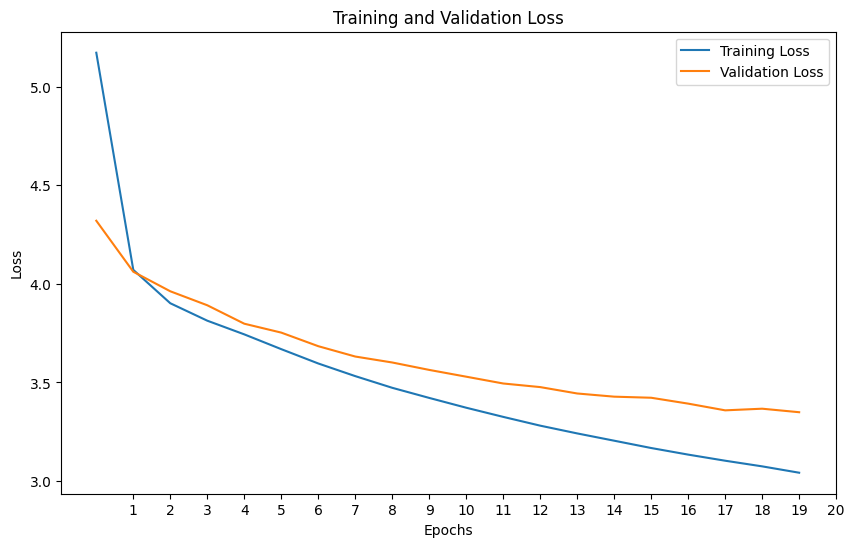

In [ ]:
def main():
    ## Load and preprocess data
    train_dataset, val_dataset, tokenizer, tokenizer_inv = load_and_preprocess_data()
    print(f"Vocabulary size: {len(tokenizer.vocab)}")
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}\n")

    ## Create data loaders
    def collate_fn(batch):
        #tokenize and pad
        tokens = [torch.tensor(tokenize(text, pad_to_len=MAX_LEN, tokenizer=tokenizer)) for text in batch]
        tokens = torch.stack(tokens)
        
        #create input-target pairs (inputs are tokens[:-1], targets are tokens[1:])
        inputs = tokens[:, :-1].contiguous()
        targets = tokens[:, 1:].contiguous()
        
        return inputs, targets
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

    ## Model hyperparameters
    vocab_size = len(tokenizer.vocab)
    d_model = 256
    nhead = 8
    num_layers = 6
    dim_feedforward = 1024
    dropout = 0.1

    ## Initialize model
    model = TransformerLM(
        vocab_size=vocab_size,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout
    ).to(DEVICE)

    ## Print model summary
    print(f"Model architecture:")
    print(f"- Embedding dimension: {d_model}")
    print(f"- Number of heads: {nhead}")
    print(f"- Number of layers: {num_layers}")
    print(f"- Feedforward dimension: {dim_feedforward}")
    print(f"- Total parameters: {sum(p.numel() for p in model.parameters())}\n")

    ## Train the model
    train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_dataset=val_dataset,
        tokenizer=tokenizer,
        tokenizer_inv=tokenizer_inv,
        epochs=20,
        lr=1e-4
    )

    ## Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xticks(range(1, 20+1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('loss-plot.png')
    plt.show()

    ## Save the model
    torch.save({
        'model_state_dict': model.state_dict(),
        'tokenizer': tokenizer,
        'tokenizer_inv': tokenizer_inv,
        'config': {
            'd_model': d_model,
            'nhead': nhead,
            'num_layers': num_layers,
            'dim_feedforward': dim_feedforward,
            'dropout': dropout
        }
    }, 'task1-transformer.pt')

    ## Evaluate on test data
    # with open("/content/shakespear_test.txt", "r") as f:
    #     lines_test = f.readlines()

    # print(f"\nTest perplexity: {}")

if __name__ == "__main__":
    main()

In [5]:
def inference(model_obj, test_file, tokenizer, tokenizer_inv, gen_tokens=10, temperature=0.6):
    ## Load the saved model
    config = model_obj['config']
    model = TransformerLM(
        vocab_size=len(tokenizer_inv),
        d_model=config['d_model'],
        nhead=config['nhead'],
        num_layers=config['num_layers'],
        dim_feedforward=config['dim_feedforward'],
        dropout=config['dropout']
    ).to(DEVICE)
    model.load_state_dict(model_obj['model_state_dict'])
    model.eval()

    ## Read and process the input from test.txt
    with open(test_file, "r") as f:
        test_dataset = [line.strip() for line in f.readlines()]

    ## Generate text and calculate perplexity
    generated_text = []
    with torch.no_grad():
        for line in test_dataset:
            text = generate_text(model, tokenizer, tokenizer_inv, context=line, gen_tokens=20)
            generated_text.append(text)
        test_loss = evaluate_losses(test_dataset, model, tokenizer)
        avg_test_loss = sum(test_loss) / len(test_loss)
        test_perplexity = np.exp(avg_test_loss)
    return generated_text, test_perplexity


model_path = 'task1-transformer.pt'
test_file = 'sample-test.txt'

model_obj = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
tokenizer = model_obj['tokenizer']
tokenizer_inv = model_obj['tokenizer_inv']
generated_texts, ppl = inference(model_obj, test_file, tokenizer, tokenizer_inv)

## Print the generated text and perplexity
print(f"\nTest perplexity: {ppl:.2f}\n")
print("Generated Text:")
for text in generated_texts:
    print(text)

100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Test perplexity: 51.82

Generated Text:
w ##e ##ll th ##e ##n imprison him if imprisonm ##e ##n ##t b ##e th ##e ##m i ##s th ##e ##e and w ##e ##ll som ##e ##thing th ##e ##e
i will pray pomp ##e ##y to r ##e ##m ##e ##c ##t ##o ##r
i ##t was a mad fantastical m ##e
er ##e h ##e would hav ##e hang ##e ##d my lord for th ##e ##i ##r own fath ##e ##r
eith ##e ##r th ##i ##s i ##s th ##e envy do ##n ##e h ##e ##r ##e 's th ##a ##t man i ##s a ##s h ##e ##a ##r
